In [1]:
import numpy as np
import pandas as pd
import os
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


#### Plotting Style

In [2]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [3]:
IN_FP = '../input/store-sales-time-series-forecasting'
TRAIN_FP = os.path.join(IN_FP, 'train.csv')
TEST_FP = os.path.join(IN_FP, 'test.csv')
HOLIDAYS_FP = os.path.join(IN_FP, 'holidays_events.csv')
OIL_FP = os.path.join(IN_FP, 'oil.csv')
TRANSACTIONS_FP = os.path.join(IN_FP, 'transactions.csv')

In [4]:
store_sales = pd.read_csv(
    TRAIN_FP,
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = store_sales.groupby('date').mean()['sales']

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']    
)

test = pd.read_csv(
    TEST_FP,
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

holidays_events = pd.read_csv(
    HOLIDAYS_FP,
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

oil = pd.read_csv(
    OIL_FP,
    parse_dates=['date'],
    infer_datetime_format=True
)

oil['date'] = oil.date.dt.to_period('D')
oil = oil.set_index(['date']).sort_index()

transactions = pd.read_csv(
    TRANSACTIONS_FP,
    parse_dates=['date'],
    infer_datetime_format=True,
)

transactions['date'] = transactions.date.dt.to_period('D')
transactions = transactions.set_index(['store_nbr','date']).sort_index()

In [5]:
family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124084   10.629630  1711.907349  1204.203735  404.300079   
2017-01-04   594.160583   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

In [6]:
print("Training Data\n", store_sales, "\n\n")
print("Test Data\n", test)

Training Data
                                      sales  onpromotion
store_nbr family     date                              
1         AUTOMOTIVE 2013-01-01   0.000000            0
                     2013-01-02   2.000000            0
                     2013-01-03   3.000000            0
                     2013-01-04   3.000000            0
                     2013-01-05   5.000000            0
...                                    ...          ...
9         SEAFOOD    2017-08-11  23.830999            0
                     2017-08-12  16.859001            4
                     2017-08-13  20.000000            0
                     2017-08-14  17.000000            0
                     2017-08-15  16.000000            0

[3000888 rows x 2 columns] 


Test Data
                                       id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0

*Note the problem requires a 16 day forecast with 1 step lead time*

## Trend
Extract long term trend with linear regression

<AxesSubplot:title={'center':'Average Sales - 365-Day Moving Average'}, xlabel='date'>

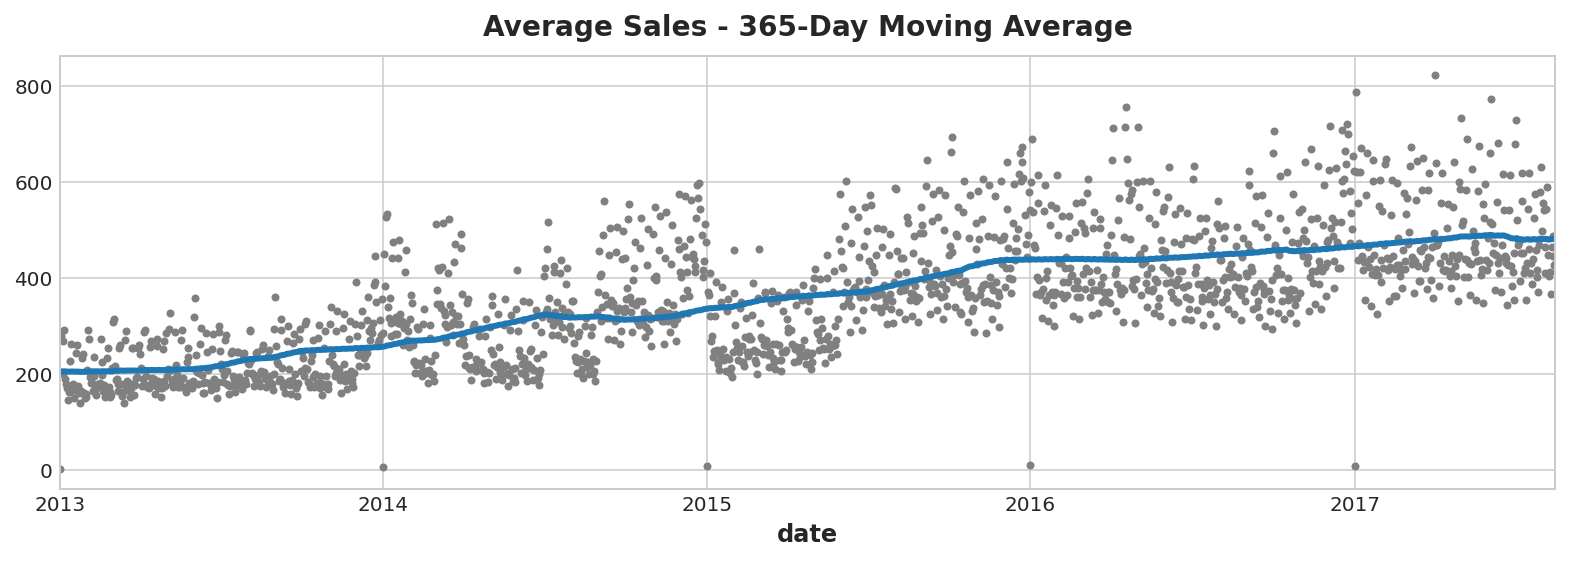

In [7]:
# Moving Average Trend
moving_average = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(style=".", color="0.5")
moving_average.plot(ax=ax, linewidth=3, title="Average Sales - 365-Day Moving Average")

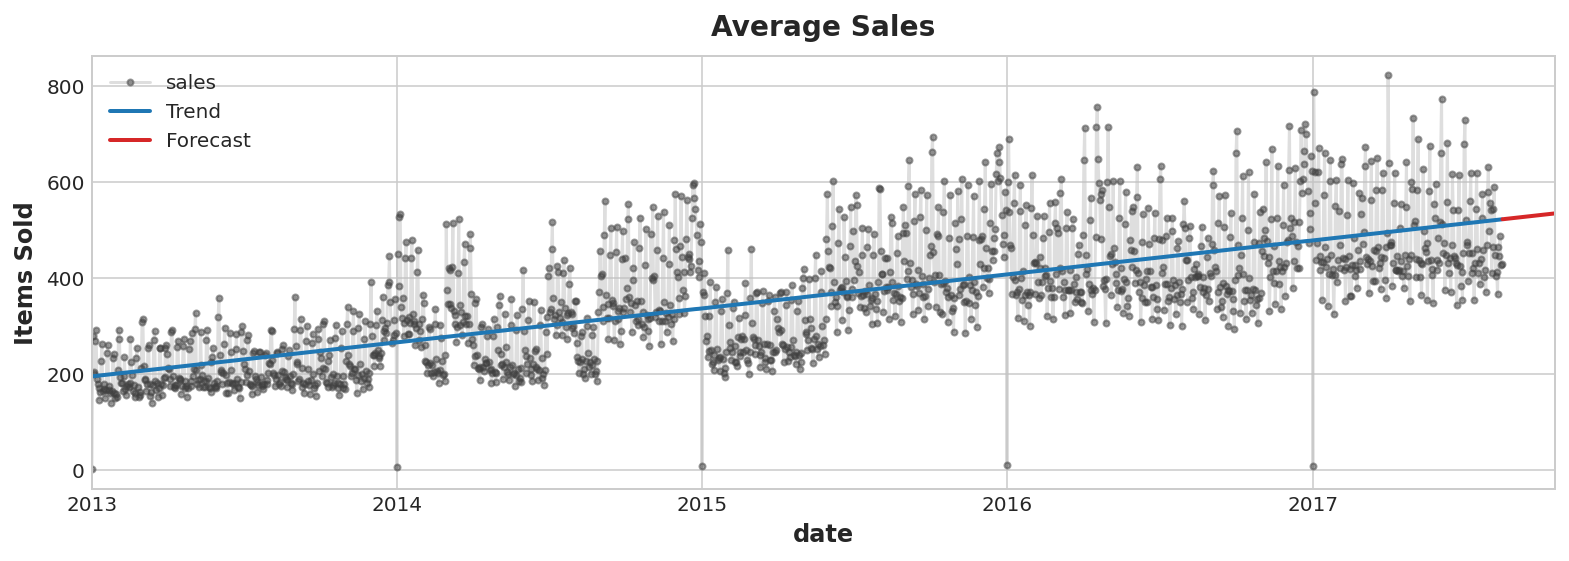

In [8]:
# Average sales polynomial trend and associated forecast

y = average_sales.copy()

dp = DeterministicProcess(
    index=y.index,
    order=1,
)

X = dp.in_sample()
X_fore = dp.out_of_sample(64)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="Items Sold")
ax = y_pred.plot(ax=ax, linewidth=2, label="Trend", color="C0")
ax = y_fore.plot(ax=ax, linewidth=2, label="Forecast", color="C3")
ax.legend()

### Individual Stores and Categories Linear Fit

In [9]:
# Fit to individual stores and categories
y_total = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

dp = DeterministicProcess(
    index=y_total.index,
    order=1,
)

X_total = dp.in_sample()
X_total_fore = dp.out_of_sample(64)

model_total = LinearRegression()
model_total.fit(X_total, y_total)

y_pred_total = pd.DataFrame(model_total.predict(X_total), index=X_total.index, columns=y_total.columns)

Text(0.5, 1.0, 'AUTOMOTIVE Sales at Store 50')

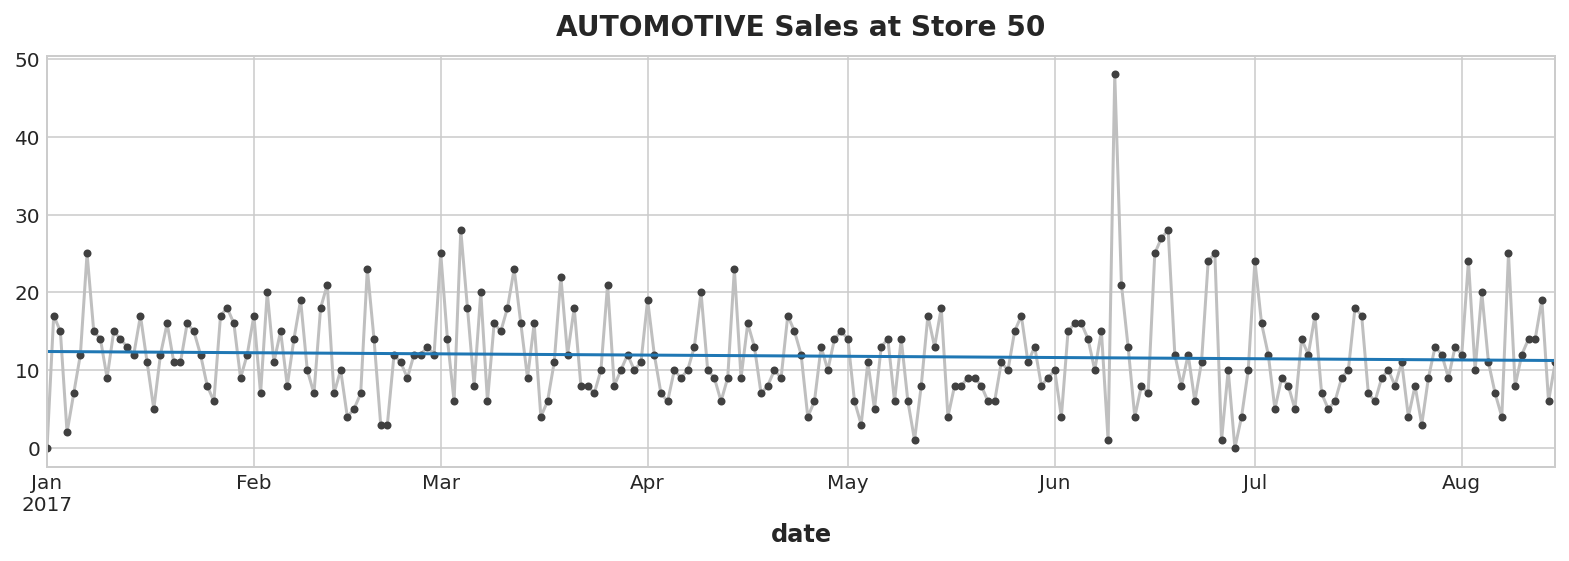

In [10]:
# Check against different store numbers and series
STORE = '50'
FAMILY = 'AUTOMOTIVE'

ax = y_total.loc(axis=1)['sales', STORE, FAMILY].plot(**plot_params)
ax = y_pred_total.loc(axis=1)['sales', STORE, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE}')

## Seasonality

In [11]:
# Seasonal plotting function

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique())
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center"        
        )
    return ax

<AxesSubplot:title={'center':'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='sales'>

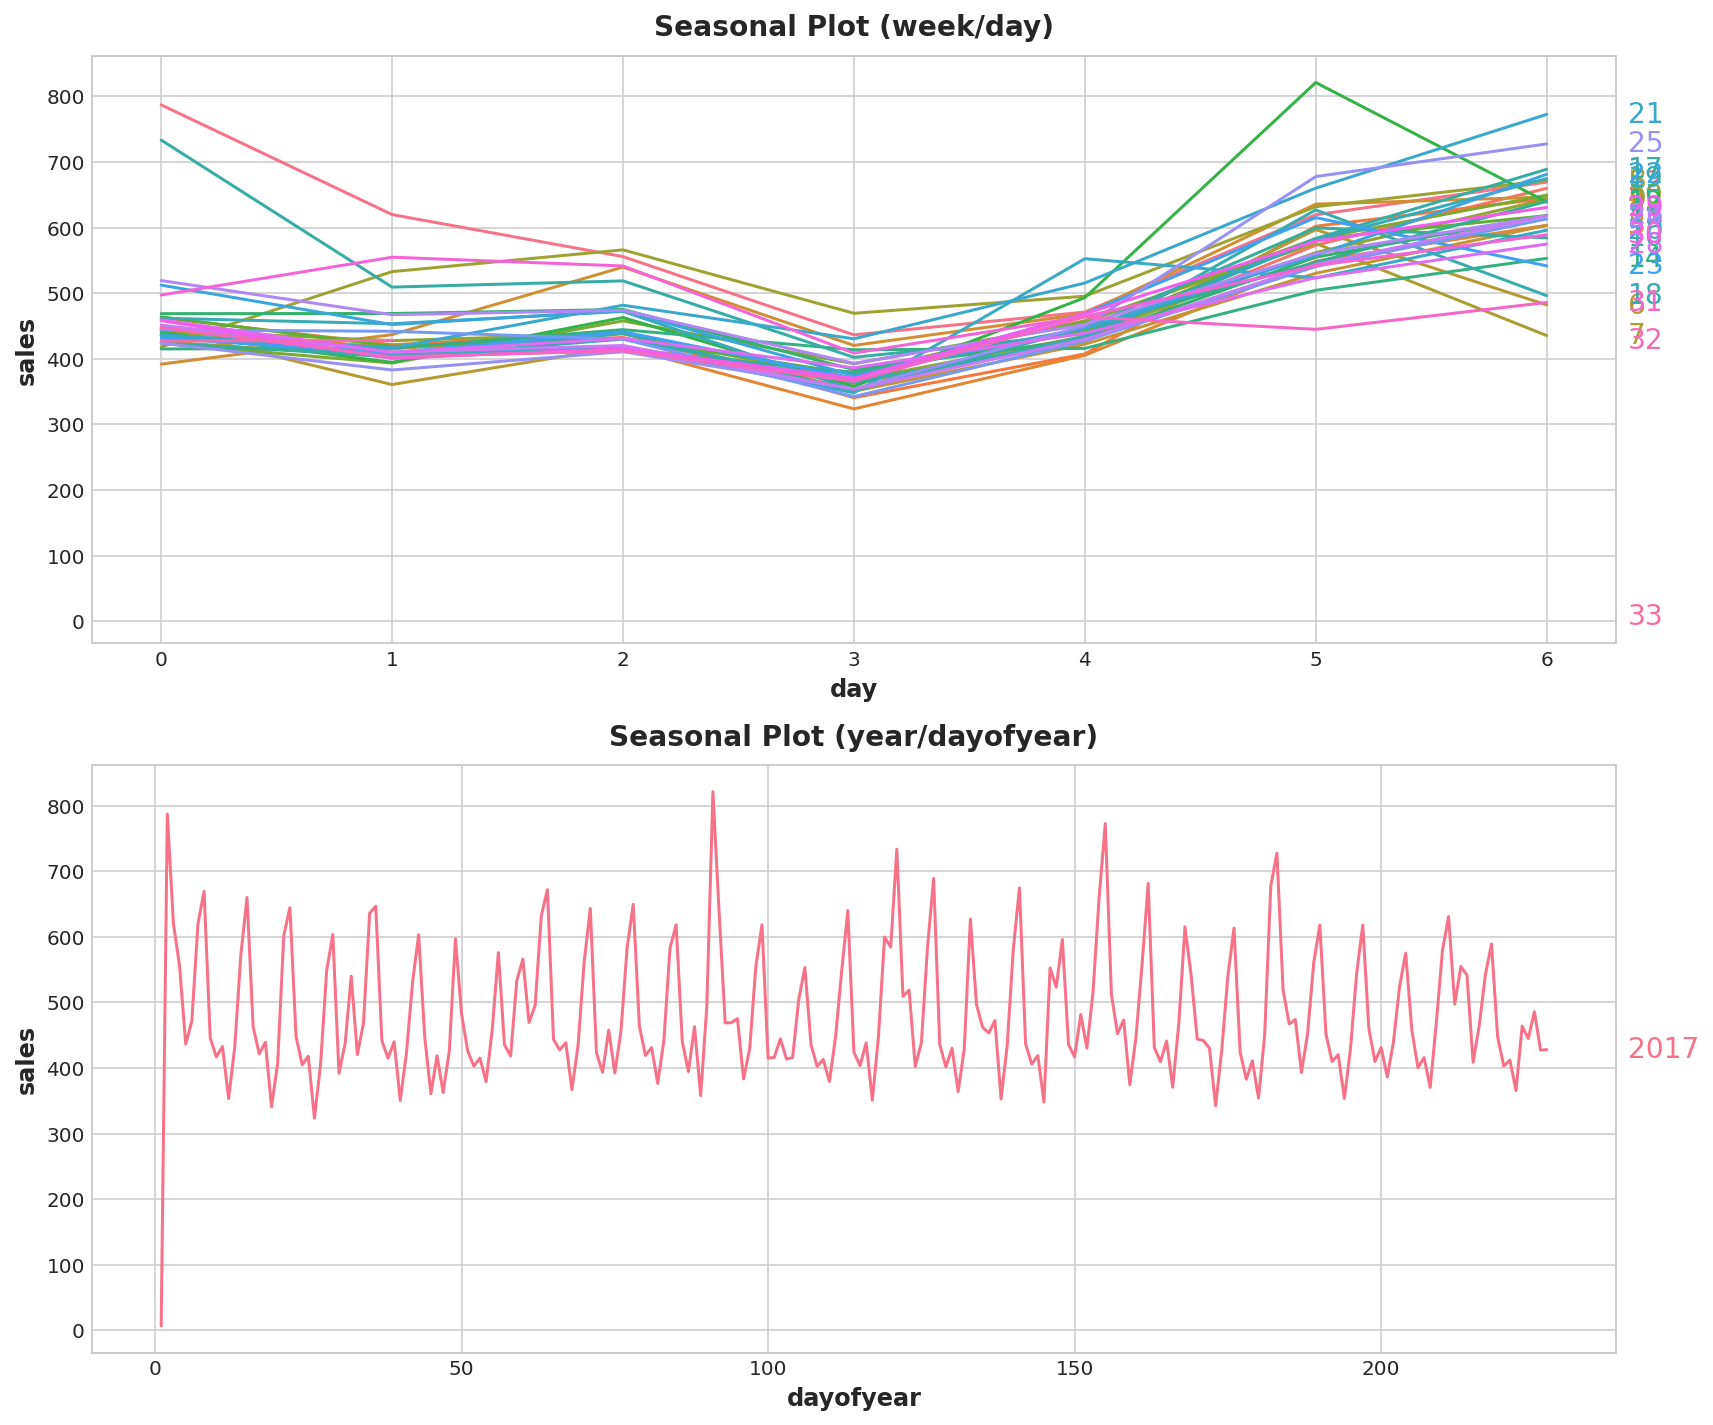

In [12]:
# Seasonal plot by week and year

X = average_sales.to_frame().loc["2017"]

X["day"] = X.index.dayofweek
X["week"] = X.index.week

X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,10))
seasonal_plot(X, y="sales", period="week", freq="day", ax=axs[0])
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=axs[1])

#### Periodogram plotting function

In [13]:
# Periodogram
def plot_periodogram(ts, detrend="linear", ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum'    
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)"
        ],
        rotation=30
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """Entry point for launching an IPython kernel.


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

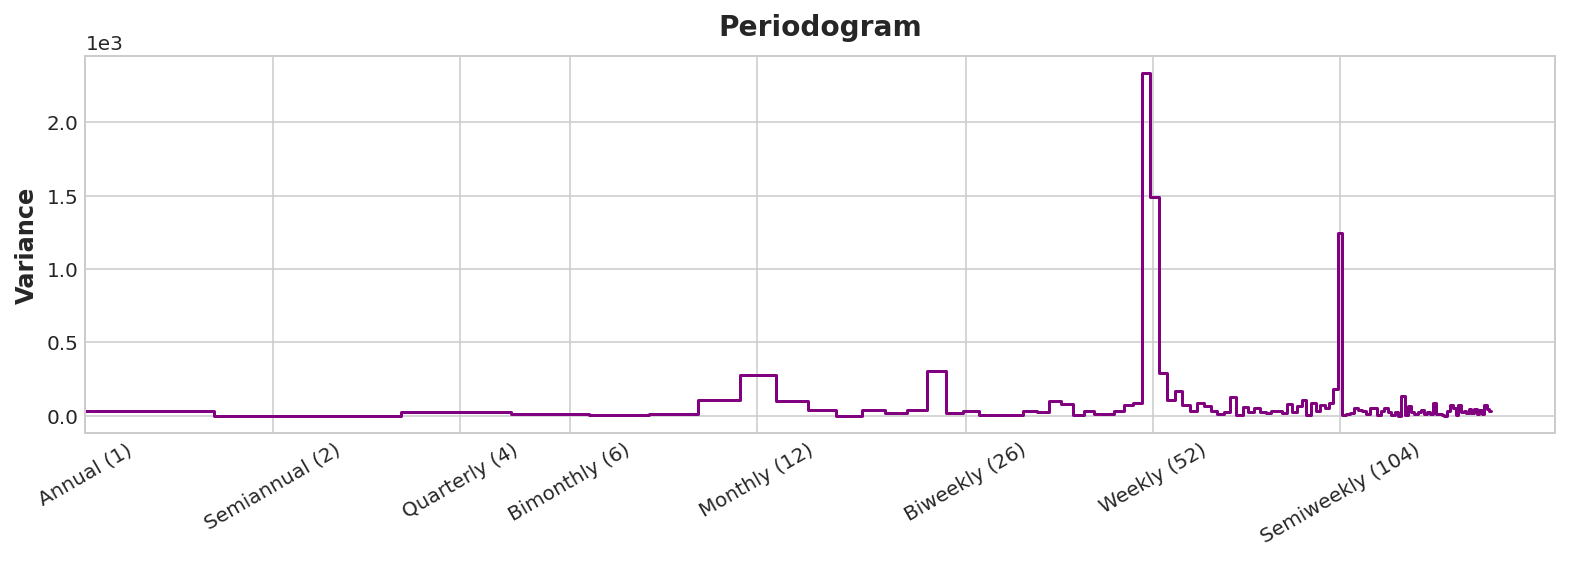

In [14]:
plot_periodogram(average_sales.loc["2017"])

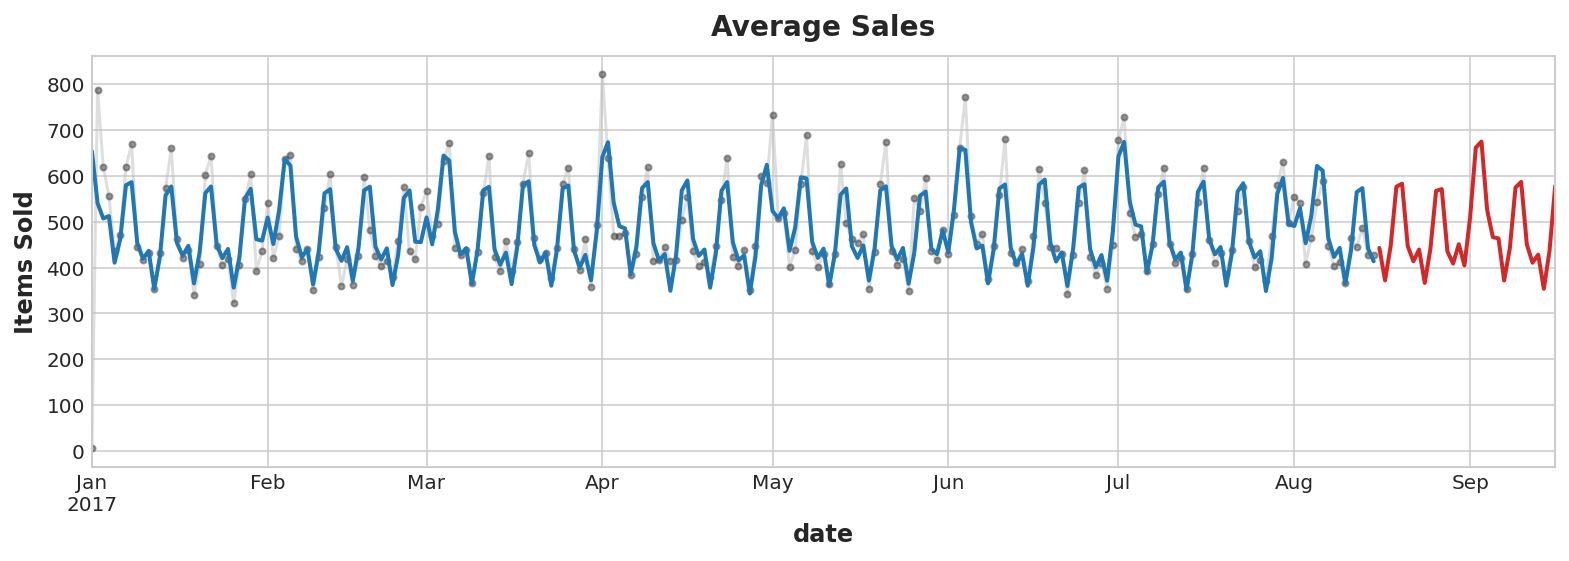

In [15]:
# Monthly and weekly seasonan
y = average_sales['2017'].copy()

fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index = y.index,
    constant = True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)

X = dp.in_sample()
X_fore = dp.out_of_sample(32)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, title="Average Sales", ylabel="Items Sold" , alpha=0.5)
ax = y_pred.plot(label="Trend", linewidth=2, color='C0')
ax = y_fore.plot(label="Prediction", linewidth=2, color='C3')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  import sys


Text(0.5, 1.0, 'Deseasonalised')

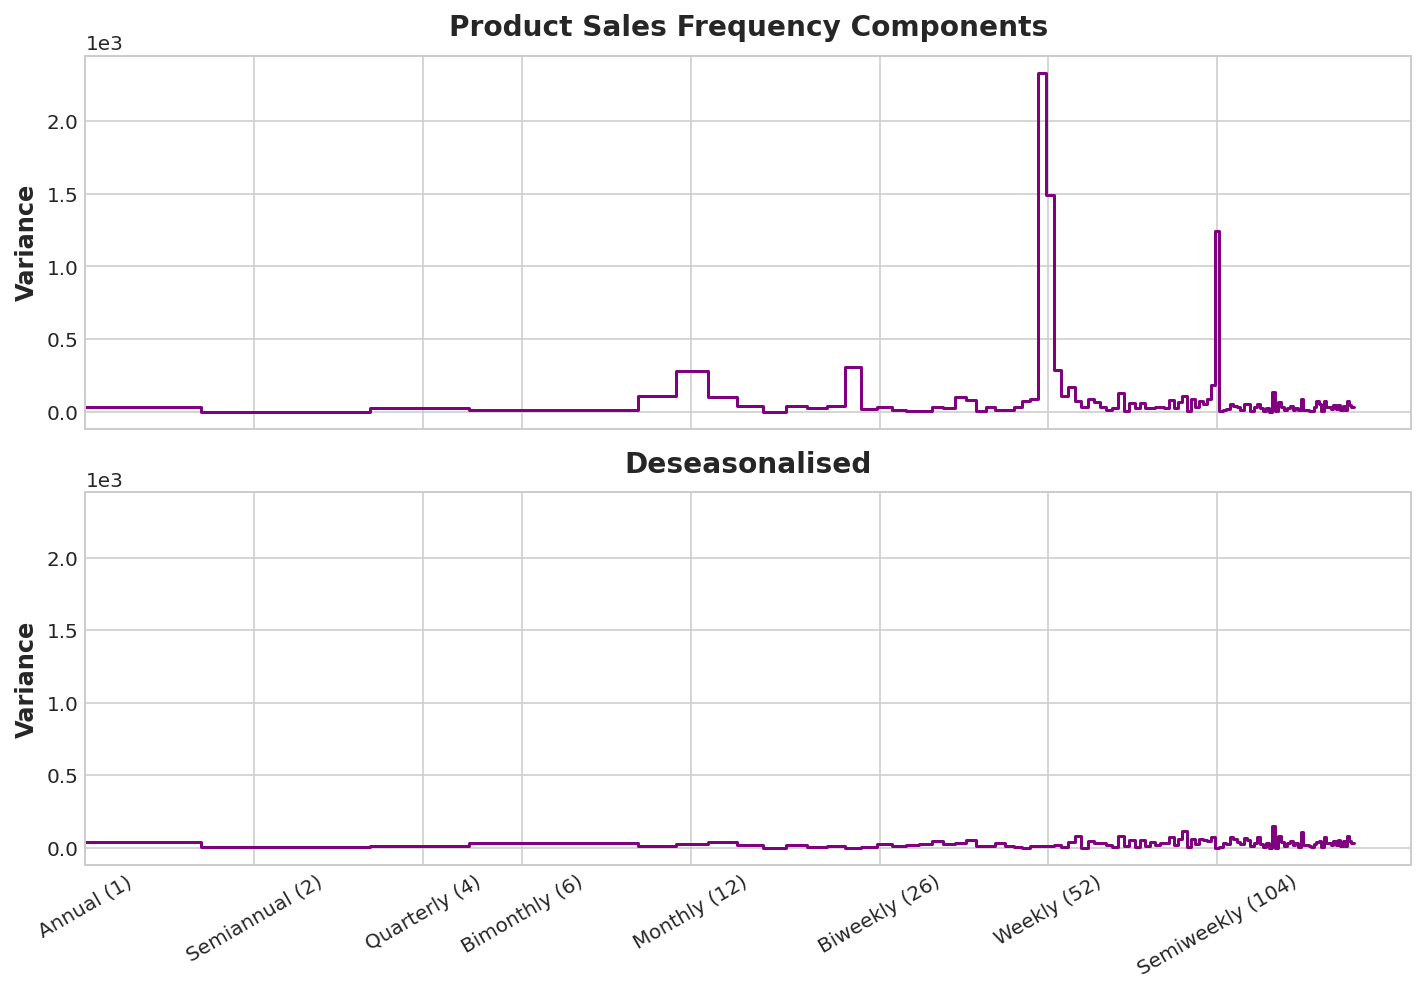

In [16]:
y_deseason = y - y_pred

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10, 7))

axs[0] = plot_periodogram(y, ax=axs[0])
axs[0].set_title("Product Sales Frequency Components")
axs[1] = plot_periodogram(y_deseason, ax=axs[1])
axs[1].set_title("Deseasonalised")

## Holidays

In [17]:
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


In [18]:
import datetime

start_date = "16/08/17"
date_1 = datetime.datetime.strptime(start_date, "%d/%m/%y")
end_date = date_1 + datetime.timedelta(days=32)
print(end_date)

2017-09-17 00:00:00


In [19]:
holidays_events.loc['2017-08-16':'2017-09-17'].head()

,type,locale,locale_name,description,transferred
date,,,,,
2017-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False


*Note: Only one local holiday in the forecasting period - could be of use in refining but not for now*

Text(0.5, 1.0, 'National and Regional Holidays')

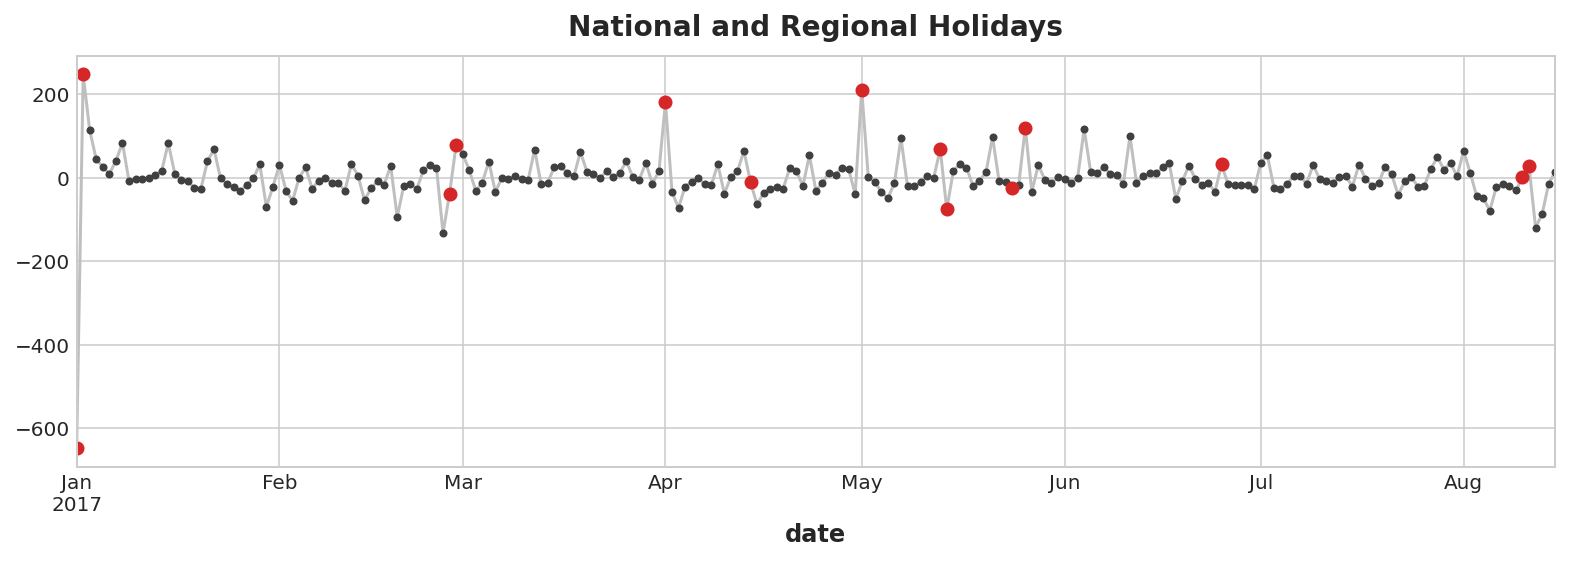

In [20]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays')

In [21]:
X_holidays = pd.get_dummies(holidays)

X2 = X.join(X_holidays, on='date').fillna(0.0)
X2.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
X_fore.index.name = 'date'

X_holidays_fore = pd.DataFrame(index=X_fore.index, columns=X_holidays.columns)
X2_fore = X_fore.join(X_holidays_fore, on='date').fillna(0.0)
X2_fore.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1.0,228.0,0.0,0.0,1.0,0.0,0.0,0.0,0.101168,-0.994869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-17,1.0,229.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.101168,-0.994869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-18,1.0,230.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.299363,-0.954139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-19,1.0,231.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.485302,-0.874347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-20,1.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.651372,-0.758758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


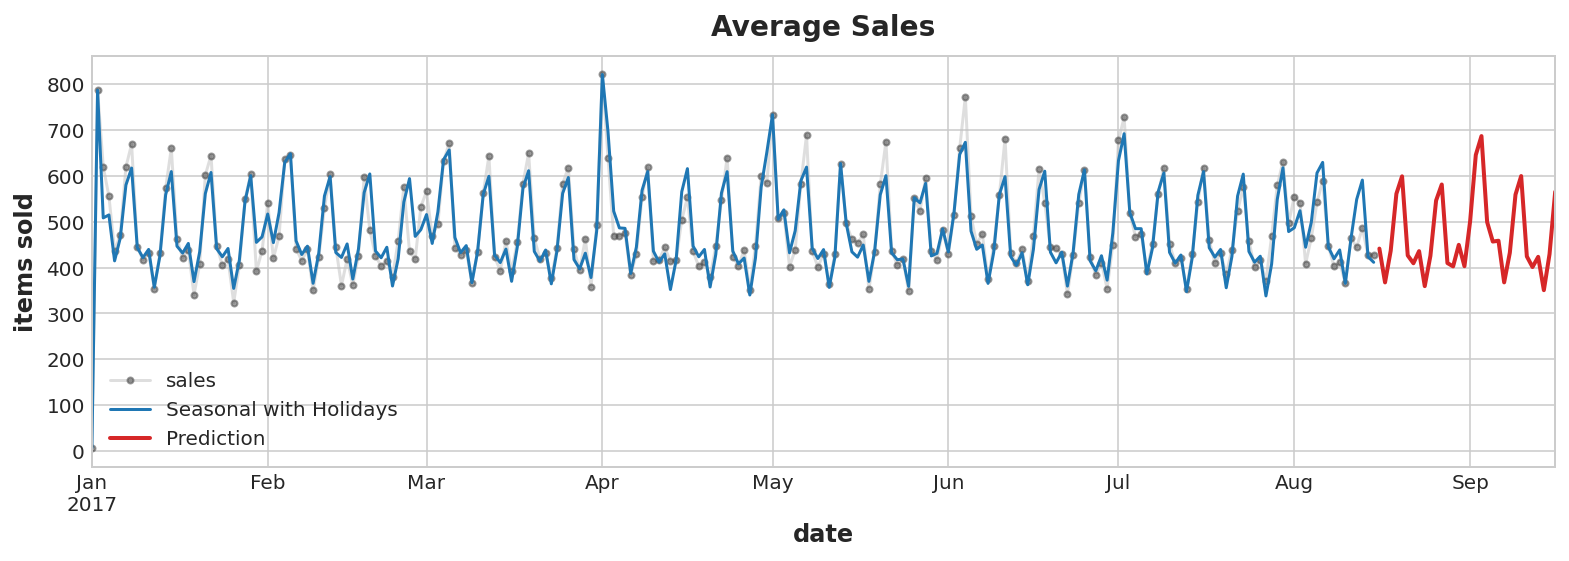

In [23]:
model = LinearRegression()
model.fit(X2,y)

y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted'
)

y_fore = pd.Series(
    model.predict(X2_fore),
    index=X2_fore.index,
    name='Fitted'
)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(label="Seasonal with Holidays")
ax = y_fore.plot(label="Prediction", linewidth=2, color='C3')
ax.legend()
y_deason_hols = y - y_pred

## Time Series Features

#### Lag Plotting Functions

In [64]:
from statsmodels.graphics.tsaplots import plot_pacf

def lagplot(x, y=None, shift=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(shift)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(alpha=0.75, s=3,)
    line_kws = dict(color='C3', )
    
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    title = f"Lag {shift}" if shift > 0 else f"Lead {shift}"
    ax.set(title=f"Lag {shift}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, leads=None, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    orig = leads is not None
    leads = leads or 0
    
    kwargs.setdefault('ncols', math.ceil((lags + orig + leads) / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(axs.flatten(), range(kwargs['nrows'] * kwargs['ncols'])):
        k -= leads + orig
        if k + 1 <= lags:
            ax = lagplot(x, y, shift=k + 1, ax=ax, **lagplot_kwargs)
            title = f"Lag {k + 1}" if k + 1 >= 0 else f"Lead {-k - 1}"
            ax.set_title(title, fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

# Check lags and autocorrelation
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1).dropna()

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


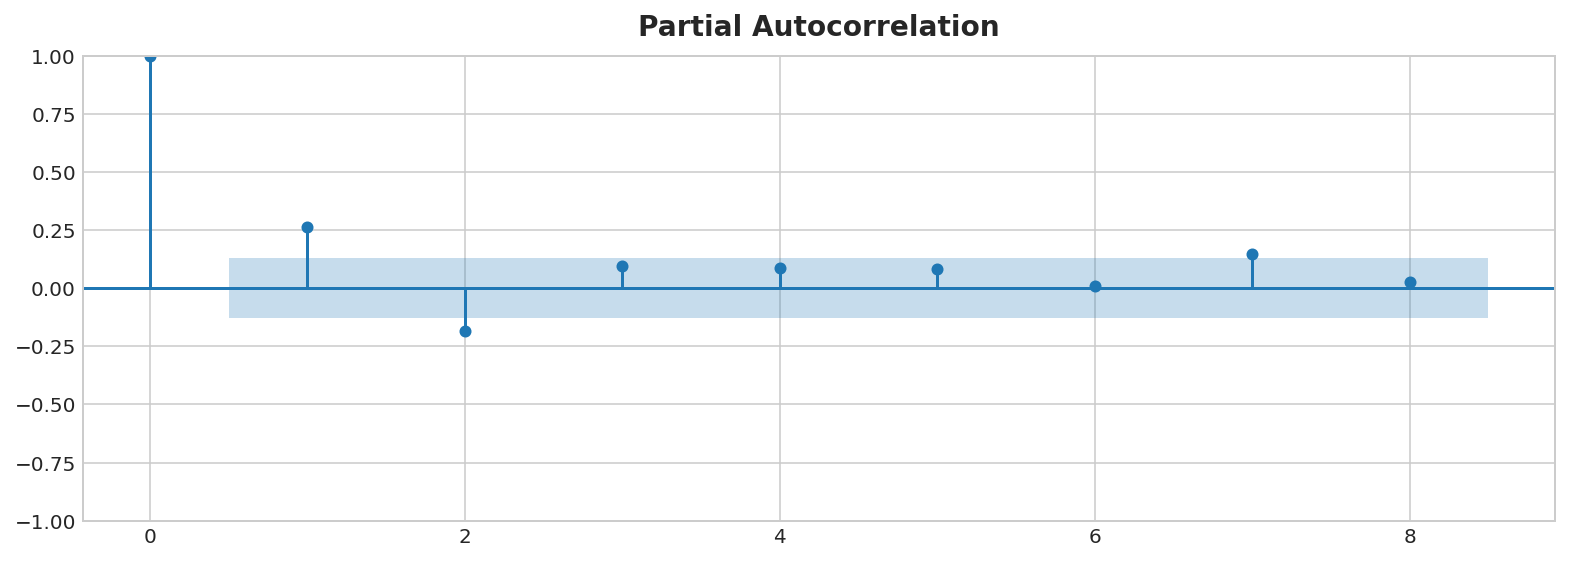

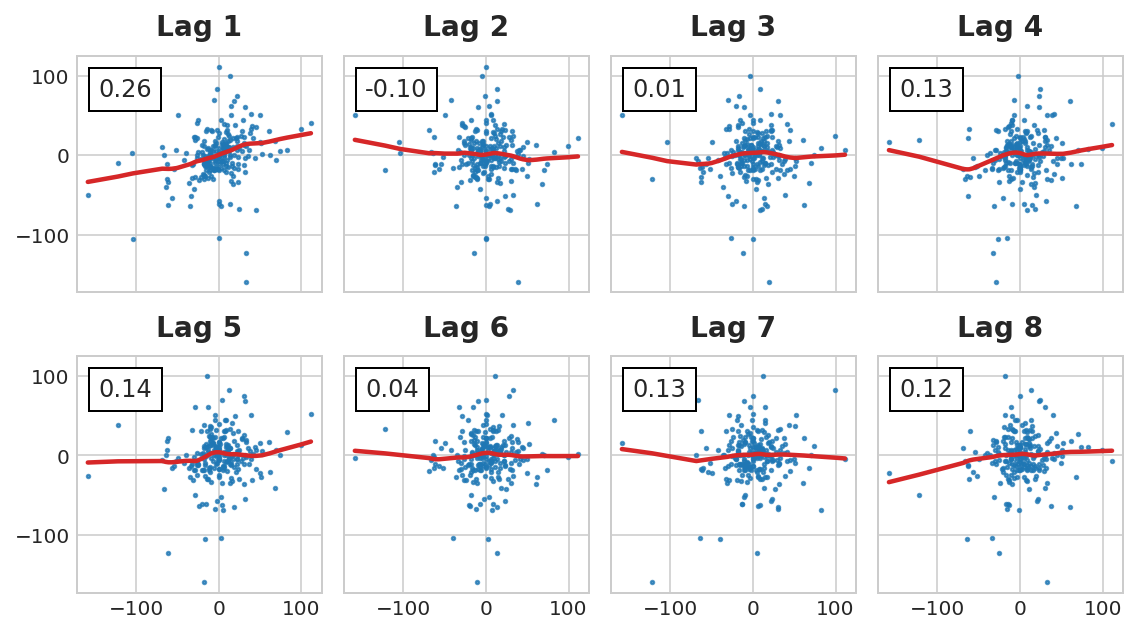

In [25]:
# Average sales trends after deseasonalising and holiday events
fig = plot_pacf(y_deason_hols, lags=8)
fig = plot_lags(y_deason_hols, lags=8, nrows=2)

Absence of strong trends in terms of average sales

## Boosted Hybrid Model

In [26]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None
    
    def fit(self, X_1, X_2, y):
        # fit the first model
        self.model_1.fit(X_1, y)
        
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=y.columns,        
        )
        
        y_resid = y - y_fit
        # Change orientation from wide to long
        y_resid = y_resid.stack().squeeze()
        
        self.model_2.fit(X_2, y_resid)
        
        self.y_columns = y.columns
        self.y_fit = y_fit
        self.y_resid = y_resid
        
    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()
        y_pred += self.model_2.predict(X_2)
        
        return y_pred.unstack()
        

#### X_1 Data Set for Regression Fit

In [27]:
y = family_sales.loc[:, 'sales']

fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index = y.index,
    constant = True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)
X_linear_1 = dp.in_sample()

In [28]:
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

X_holidays_1 = pd.get_dummies(holidays)

X_1 = X_linear_1.join(X_holidays_1, on='date').fillna(0.0)
X_1 = X_linear_1
X_1.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869


#### X_2 Data for XGBoost Fit

In [29]:
X_2 = family_sales.drop('sales', axis=1).stack()
le = LabelEncoder()
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])
X_2['day'] = X_2.index.day
X_2.head()

,family,onpromotion,day
date,,,
2017-01-01,0,0.000000,1
2017-01-01,1,0.000000,1
2017-01-01,2,0.000000,1
2017-01-01,3,0.703704,1
2017-01-01,4,0.000000,1


#### Train Hybrid

In [30]:
from pyearth import Earth
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [31]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

In [32]:
model1_options = [LinearRegression(), Earth(), ElasticNet(), Lasso(), Ridge()]
model2_options = [XGBRegressor(), ExtraTreesRegressor(), RandomForestRegressor(), KNeighborsRegressor(), MLPRegressor()]

In [33]:
def model_mse(model1, model2):
    model = BoostedHybrid(
        model1,
        model2,
    )
    
    model.fit(X1_train, X2_train, y_train)
    y_fit = model.predict(X1_train, X2_train).clip(0.0)
    y_pred = model.predict(X1_valid, X2_valid).clip(0.0)
    train_mse = mean_squared_error(y_train, y_fit, squared=False)
    valid_mse = mean_squared_error(y_valid, y_pred, squared=False)
    
    print (f'TRAIN RMSE:{train_mse}')
    print (f'VALIDATION RMSE:{valid_mse}\n')

    return train_mse, valid_mse

In [34]:
import warnings
warnings.filterwarnings('ignore')
                        
res = {}
lowest_error = float('inf')
best_combo = None

for num1, model1 in enumerate(model1_options):
    for num2, model2 in enumerate(model2_options):
        train_error, valid_error = model_mse(model1, model2)
        
        if max(train_error, valid_error) < lowest_error:
            lowest_error = max(train_error, valid_error)
            best_combo = [(num1, num2), (train_error, valid_error)]
            
        res[(num1, num2)] = (train_error, valid_error)

TRAIN RMSE:24.40600298206093
VALIDATION RMSE:66.76730025788585

TRAIN RMSE:2.150629290705781
VALIDATION RMSE:67.79316093665638

TRAIN RMSE:29.731045800681922
VALIDATION RMSE:65.89667538614844

TRAIN RMSE:60.234205668335164
VALIDATION RMSE:63.94830504165534

TRAIN RMSE:70.54219142994154
VALIDATION RMSE:59.832840060747586

TRAIN RMSE:24.019507547090416
VALIDATION RMSE:83.42064573957718

TRAIN RMSE:2.1812394972054823
VALIDATION RMSE:85.61107547429661

TRAIN RMSE:29.339568746188803
VALIDATION RMSE:83.0817113934041

TRAIN RMSE:58.11772675808944
VALIDATION RMSE:82.71095609383924

TRAIN RMSE:67.28616305105443
VALIDATION RMSE:77.01568470781804

TRAIN RMSE:41.23191782953173
VALIDATION RMSE:102.28971544422146

TRAIN RMSE:3.8385806115018632
VALIDATION RMSE:102.83389669234134

TRAIN RMSE:39.948125878688344
VALIDATION RMSE:95.16017940848549

TRAIN RMSE:84.80360451103216
VALIDATION RMSE:94.13440575011187

TRAIN RMSE:101.62310602016149
VALIDATION RMSE:89.96891717048715

TRAIN RMSE:23.960222396206433


In [35]:
print(f'{model1_options[best_combo[0][0]]} and {model2_options[best_combo[0][1]]}\nTrain RMSE: {best_combo[1][0]:.2f}, Valid RMSE: {best_combo[1][1]:.2f}')

LinearRegression() and KNeighborsRegressor()
Train RMSE: 60.23, Valid RMSE: 63.95


In [39]:
space={ 
    'n_neighbors': hp.quniform("n_neighbors", 2, 10, 1),
    'leaf_size': hp.quniform('leaf_size', 10, 100, 5),
    }

def objective(space):
    train_mse, valid_mse = model_mse(
        LinearRegression(),
        KNeighborsRegressor(n_neighbors=int(space['n_neighbors']), leaf_size=int(space['leaf_size']))
    )
    
    print (f'TRAIN RMSE:{train_mse}')
    print (f'VALIDATION RMSE:{valid_mse}\n')

    return {'loss': max(valid_mse, train_mse), 'status': STATUS_OK }

In [40]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

TRAIN RMSE:65.34927144029145                          
VALIDATION RMSE:61.41490382335833                     

TRAIN RMSE:65.34927144029145                          
VALIDATION RMSE:61.41490382335833                     

TRAIN RMSE:64.78972763545345                                                   
VALIDATION RMSE:62.22526070120415                                              

TRAIN RMSE:64.78972763545345                                                   
VALIDATION RMSE:62.22526070120415                                              

TRAIN RMSE:57.34272669456168                                                   
VALIDATION RMSE:66.03035014917418                                              

TRAIN RMSE:57.34272669456168                                                   
VALIDATION RMSE:66.03035014917418                                              

TRAIN RMSE:63.26756781347646                                                   
VALIDATION RMSE:63.80433047417543                     

In [41]:
print(best_hyperparams)

{'leaf_size': 40.0, 'n_neighbors': 6.0}


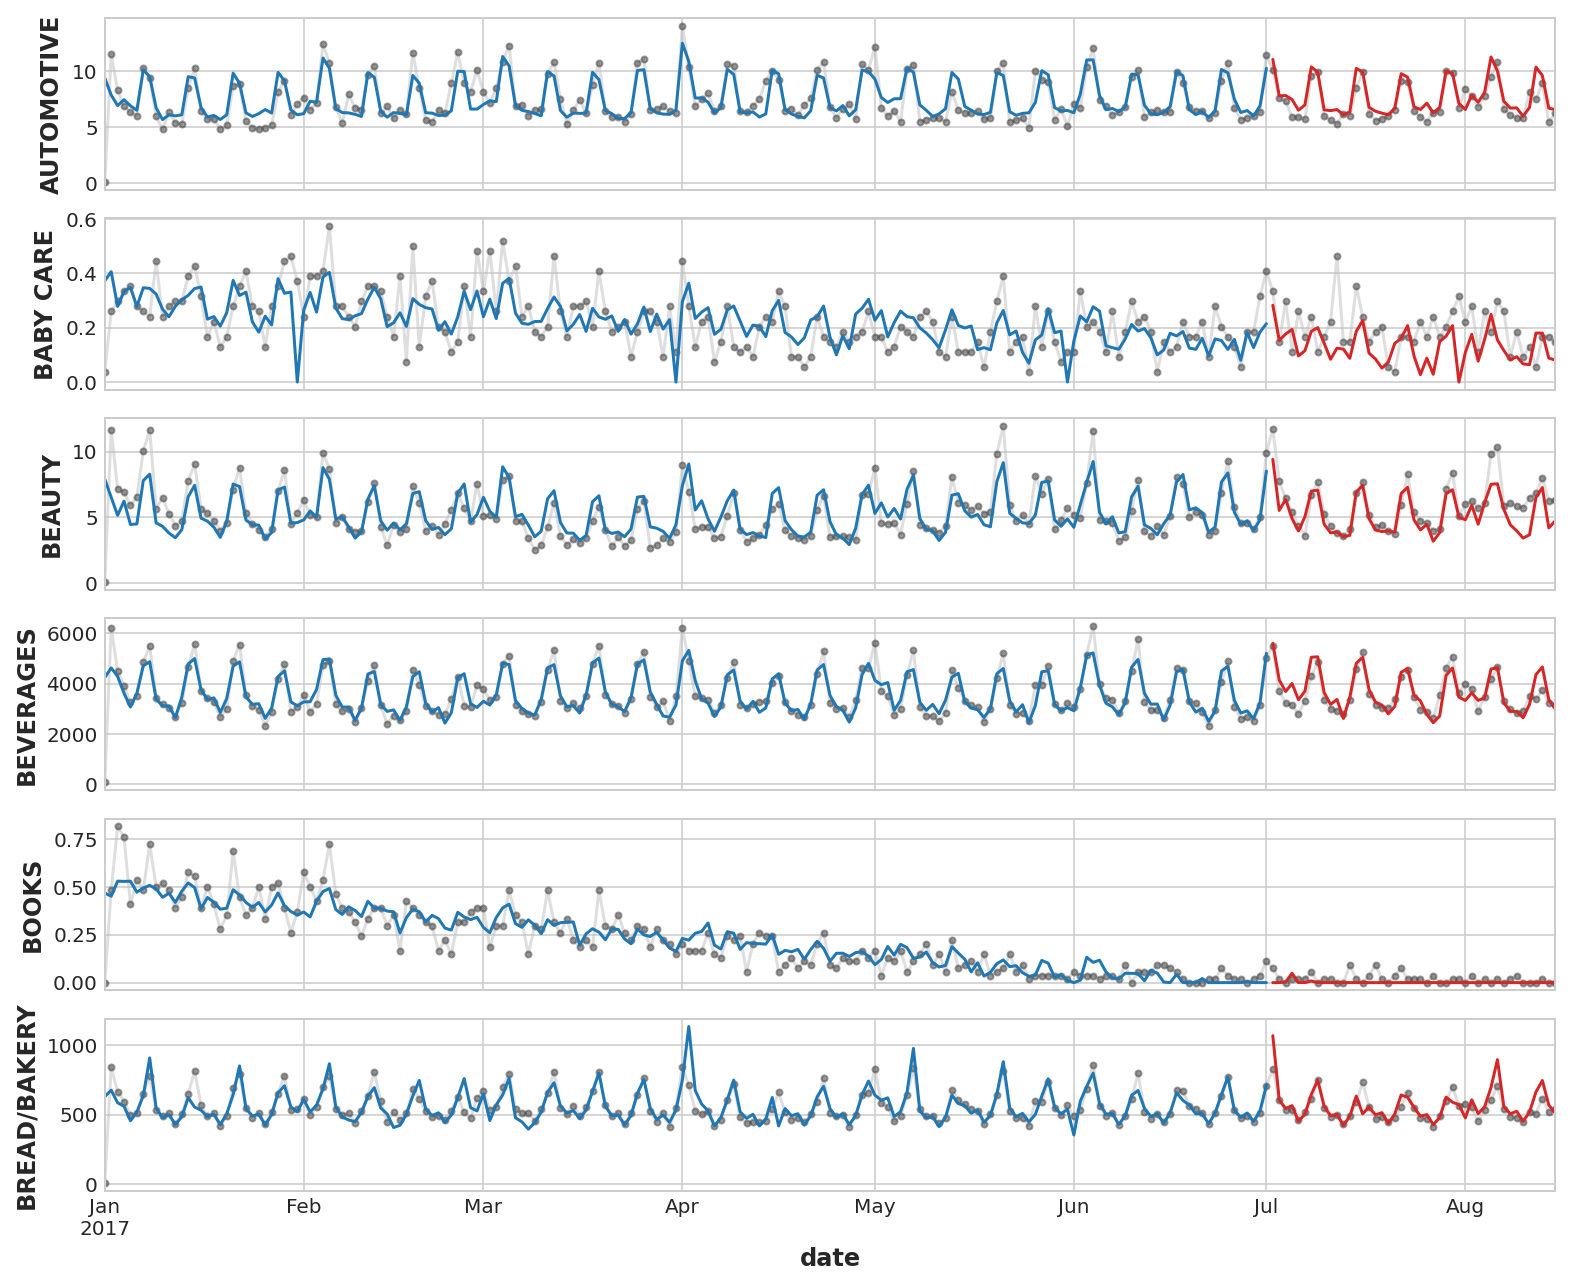

In [43]:
model_tuned = BoostedHybrid(
        LinearRegression(),
        KNeighborsRegressor(n_neighbors=int(best_hyperparams['n_neighbors']), leaf_size=int(best_hyperparams['leaf_size']))
    )

model_tuned.fit(X1_train, X2_train, y_train)
y_fit = model_tuned.predict(X1_train, X2_train).clip(0.0)
y_pred = model_tuned.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

In [44]:
train_mse = mean_squared_error(y_train, y_fit, squared=False)
valid_mse = mean_squared_error(y_valid, y_pred, squared=False)
print(f'Train MSE: {train_mse:.2f}\nValidation MSE: {valid_mse:.2f}')

Train MSE: 62.12
Validation MSE: 62.99


In [53]:
# Naive forecast
days_ahead = 14
y_naive = y.shift(days_ahead).dropna().loc['2017-01-17':'2017-08-15']
y_values = y.loc['2017-01-17':]
naive_mse = mean_squared_error(y_values, y_naive, squared=False)
print(f'Naive forecast {days_ahead} days ahead\nMSE:{naive_mse:.2f}')

Naive forecast 14 days ahead
MSE:83.94


## Direc Strategy

In [65]:
# Helper functions

def make_multistep(ts, steps):
    return pd.concat(
        {
            f'y_step_{i+1}': ts.shift(-i) for i in range(16)
        },
        axis=1).dropna()

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [66]:
y = family_sales.loc[:, 'sales']
X = make_lags(y, 4)
y = make_multistep(y, 16)

y, X = y.align(X, join='inner', axis=0)

In [67]:
le = LabelEncoder()

X = (X
     .stack('family')
     .reset_index('family')
     .assign(family=lambda x: le.fit_transform(x.family))
    )

y = y.stack('family')

In [77]:
from sklearn.multioutput import RegressorChain

model = RegressorChain(
            KNeighborsRegressor(
                n_neighbors=int(best_hyperparams['n_neighbors']),
                leaf_size=int(best_hyperparams['leaf_size']))
)

model.fit(X, y)

y_pred = pd.DataFrame(
    model.predict(X),
    index=y.index,
    columns=y.columns
).clip(0.0)

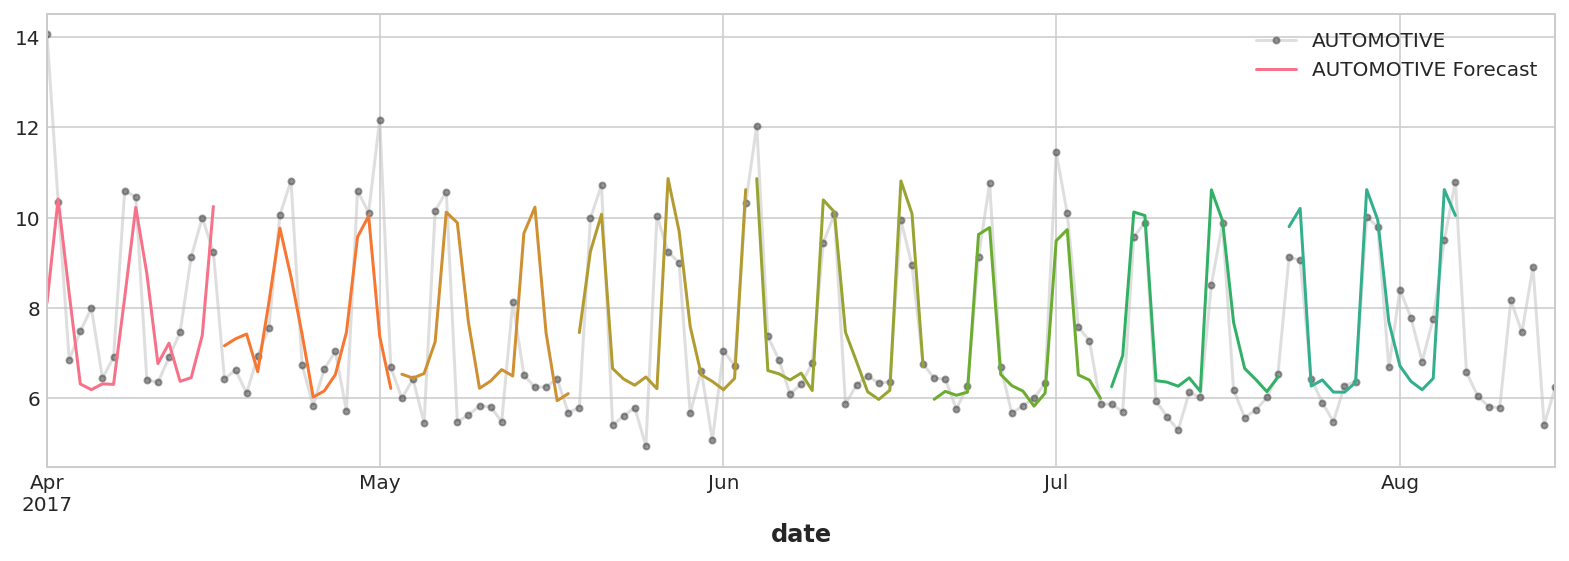

In [78]:
FAMILY = 'AUTOMOTIVE'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])

# Other Considerations
## Oil Price

In [ ]:
oil['average_store_sales'] = average_sales
oil.tail()

Note the data appears to extend into the forecasting period which is not realistic

In [ ]:
def corrPlot(X, x_param, y_param, dates=None):   
    x_ = X[x_param]
    y_ = X[y_param]
    
    if dates:
        x_ = x_.loc[dates]
        y_ = y_.loc[dates]

    corr = y_.corr(x_)

    scatter_kws = dict(
        alpha=0.75,
        s=5,
    )
    line_kws = dict(color='C3', )


    fig, ax = plt.subplots(figsize=(5,5))
    ax = sns.regplot(
        x=x_,
        y=y_,
        scatter_kws = scatter_kws,
        line_kws=line_kws,
        lowess=True,
        ax=ax
    )

    from matplotlib.offsetbox import AnchoredText
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)

In [ ]:
sales_ma = oil['average_store_sales'].rolling(
    window=50,
    center=True,
    min_periods=5,
).mean()   

fig, ax = plt.subplots(figsize=(10,5))
ax = oil['dcoilwtico'].plot(color='C0', title="Store Sales and Oil Price (Inverted)", ylabel="Oil Price", label="Oil Price")
ax.legend()
ax.invert_yaxis()

ax = sales_ma.plot(color='C3', label="Store Sales 50-Day Moving Average", secondary_y=True)
ax.legend()
ax.set_ylabel('Store Sales')

In [ ]:
corrPlot(oil, x_param='dcoilwtico', y_param='average_store_sales')

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax = oil['dcoilwtico'].loc['2017-06-01':'2017-08-15'].plot(color='C0', title="Oil Price", label='Oil Price')
ax = oil['dcoilwtico'].loc['2017-08-16':].plot(color='C3', linewidth=2, label='Oil Price Forecasting Period')
ax.legend()

## Transactions

In [ ]:
transactions.tail()

In [ ]:
average_transactions = pd.DataFrame(transactions.groupby('date').mean()['transactions'])
sales_transactions = average_transactions.join(average_sales, on='date')

sales_transactions = pd.concat([
    average_transactions,
    average_sales
], axis=1)

corrPlot(sales_transactions, x_param='transactions', y_param='sales')